CCI策略实现
向量填充：交易信号和持仓分开写，逻辑清晰
循环遍历

In [1]:
import numpy as bnp
import pandas as pd 
import talib as ta 
import tushare as ts
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
%matplotlib inline
import datetime as dt
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.sans-serif']=['SimHei']

## 数据获取和数据处理

In [2]:
sns.set()
stock = ts.get_k_data('600030','2018-05-31','2019-05-31')
stock.set_index('date',inplace=True)
stock.head()

,open,close,high,low,volume,code
date,,,,,,
2018-05-31,17.850,18.182,18.201,17.772,872127.0,600030
2018-06-01,18.045,18.113,18.416,17.908,779368.0,600030
2018-06-04,18.191,18.230,18.386,18.055,539591.0,600030
2018-06-05,18.240,18.308,18.347,18.025,560936.0,600030
2018-06-06,18.240,18.240,18.367,18.055,524775.0,600030


In [3]:
stock['cci'] = ta.CCI(np.asarray(stock['high']),np.asarray(stock['low']),np.asarray(stock['close']),timeperiod=20)   #talib里面传递数据必须是ndarray,不能是series

In [4]:
stock.tail()

,open,close,high,low,volume,code,cci
date,,,,,,,
2019-05-27,20.05,20.63,20.74,19.92,1666910.0,600030,-27.318933
2019-05-28,20.48,20.59,20.88,20.46,1223126.0,600030,-4.840153
2019-05-29,20.41,20.55,20.80,20.40,899946.0,600030,3.739828
2019-05-30,20.40,20.21,20.45,20.06,951650.0,600030,-26.874941
2019-05-31,20.16,20.13,20.35,20.12,573655.0,600030,-17.240974


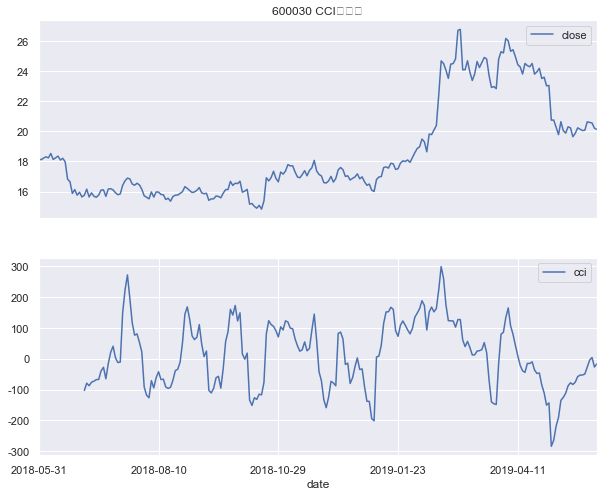

In [5]:
#绘制CCI指标图
plt.subplot(2,1,1)
plt.title('600030 CCI指标图')
plt.gca().axes.get_xaxis().set_visible(False)    #不显示横坐标
stock['close'].plot(figsize=(10,8))
plt.legend()
plt.subplot(2,1,2)
stock['cci'].plot(figsize=(10,8))
plt.legend()
plt.show()

## 交易信号，持仓信号和策略逻辑

In [7]:
#产生开仓信号时应使用昨日及前日CCI，以避免未来数据
stock['yes_cci'] = stock['cci'].shift(1)
stock['daybeforeyes_cci'] = stock['cci'].shift(2)

In [9]:
#产生开仓信号
#开多信号，当前二日cci小于-100，昨日cci大于-100则记为开多信号
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci']<-100, stock['yes_cci']>-100), 1,np.nan)
#开空信号，当前二日CCI大于100，昨日cci小于100则几位开空信号
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci']>100, stock['yes_cci']<100), -1,stock['signal'])
# stock['signal'] = nop.where((stock['daybeforeyes_cci']>100) & (stock['yes_cci']<100), -1,stock['signal'])
stock['signal'] = stock['signal'].ffill()   #在下一个交易信号产生之前，一直都是保持上一个交易信号不变，所以用向前填充给
stock['signal'] = stock['signal'].fillna(0)   #把最前面没有交易信号产生时的数据填充为0

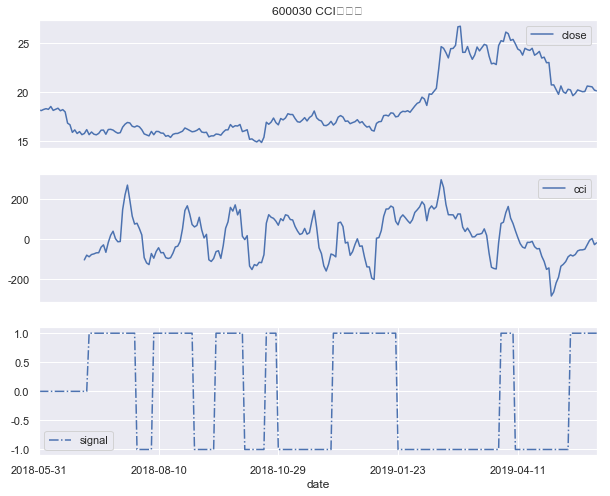

In [13]:
#绘制CCI指标图
plt.subplot(3,1,1)
plt.title('600030 CCI开仓图')
plt.gca().axes.get_xaxis().set_visible(False)    #不显示横坐标
stock['close'].plot(figsize=(10,8))
plt.legend()
plt.subplot(3,1,2)
stock['cci'].plot(figsize=(10,8))
plt.gca().axes.get_xaxis().set_visible(False)
plt.legend()
plt.subplot(3,1,3)
stock['signal'].plot(figsize=(10,8), linestyle='-.')
plt.legend()
plt.show()

## 计算收益并可视化

In [15]:
stock['pct_change'] = stock['close'].pct_change()   #计算每日离散收益

In [19]:
#计算策略每日收益
stock['strategy_return'] = stock['pct_change']*stock['signal']  #这里不用加shift(1),因为之前计算CCI的时候已经考虑了未来数据
# 计算股票累计收益 
stock['return'] = (stock['pct_change']+1).cumprod()
# 计算策略累计收益率
stock['strategy_cum_return'] = (stock['strategy_return']+1).cumprod()

In [20]:
stock.tail(20)

,open,close,high,low,volume,code,cci,yes_cci,daybeforeyes_cci,signal,pct_change,strategy_return,return,strategy_cum_return
date,,,,,,,,,,,,,,
2019-05-06,21.60,20.74,21.97,20.74,2795890.0,600030,-283.672691,-143.227815,-150.503025,-1.0,-0.099826,0.099826,1.140689,1.030669
2019-05-07,20.94,20.75,20.98,20.12,2134660.0,600030,-263.698318,-283.672691,-143.227815,-1.0,0.000482,-0.000482,1.141239,1.030172
2019-05-08,20.10,20.27,20.75,20.00,1462802.0,600030,-218.401989,-263.698318,-283.672691,-1.0,-0.023133,0.023133,1.114839,1.054003
2019-05-09,19.98,19.78,20.20,19.76,1653380.0,600030,-190.179619,-218.401989,-263.698318,-1.0,-0.024174,0.024174,1.087889,1.079482
2019-05-10,20.10,20.64,20.90,19.75,2696132.0,600030,-134.926965,-190.179619,-218.401989,-1.0,0.043478,-0.043478,1.135189,1.032548
2019-05-13,20.20,20.04,20.38,19.90,1351193.0,600030,-125.253643,-134.926965,-190.179619,-1.0,-0.029070,0.029070,1.102189,1.062564
2019-05-14,19.81,19.88,20.19,19.79,1144871.0,600030,-111.697807,-125.253643,-134.926965,-1.0,-0.007984,0.007984,1.093389,1.071047
2019-05-15,20.07,20.30,20.37,20.00,1359898.0,600030,-87.903953,-111.697807,-125.253643,-1.0,0.021127,-0.021127,1.116489,1.048419
2019-05-16,20.27,20.23,20.34,20.09,913705.0,600030,-78.131253,-87.903953,-111.697807,1.0,-0.003448,-0.003448,1.112639,1.044804


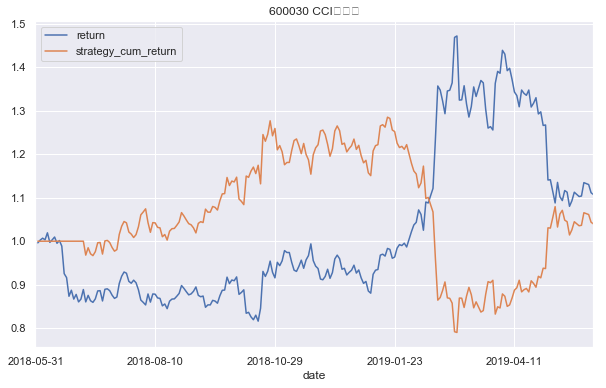

In [22]:
stock[['return','strategy_cum_return']].plot(figsize=(10,6))
plt,title('600030 CCI收益图')
plt.legend()
plt.show()